In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from emissions.trainer import Trainer
from emissions.data import load_data, clean_data
from sklearn.metrics import plot_confusion_matrix

# Background

**ABQ CURRENT POLICY**

- New Mexico emissions tests must be performed on all Bernalillo County vehicles 35 years old and newer.
- All diesel vehicles are exempt from emissions testing.
- Vehicles weighing more than 10,000 lbs do not require an emissions test.
- Any vehicle (including gas-electric hybrid vehicles) must pass an emissions test every two years, or any time the vehicle’s ownership changes, even if the emissions inspection sticker has not yet expired.
- Motorcycles, ATV’s, boats, and scooters do not require an emissions test.

**ABQ CURRENT EMISSIONS TESTING INCLUDES:**

- Pollution control equipment check that includes the catalytic converter and other connections.
- On-Board Diagnostic (OBDII) computer car emission test on vehicles 1996 and newer.
- Any visible car smoke test to uncover burning oil or poor fuel combustion that results in toxic emissions.
- Gas cap check to search for vapor leaks.
- Tailpipe exhaustion analysis on vehicles manufactured between 1983 and 1995.

**ABQ Failed Emissions Test Resource Center**
- The Vehicle Pollution Management Division (VPMD) offers one free retest for vehicles that do not pass an emissions test within 90 days of the failed test date

# Whether our solution is promising?

For instance, if we had implemented our solution for 2020, would the vehicle pollutions could have been reduced for ABQ city?

**Summary**
1. Is 2020 data different from previous years?
    - No big changes in number of total tests for 2020
    - No big changes share of fails changing for 2020
    - No big changes in testing speed for 2020
    - It seems that Covid didn't have big impact on vehicle emissions test in 2020
2. How different 2020 could have been with implementation of our solution
    - see the end of this notebook
3. How different 2019 could have been with implementation of our solution
    - see the end of this notebook

## exploration of 2020 data

In [3]:
from emissions.data import load_data
df = load_data()
df.head()

----------------start loading data----------------
Data loaded: 187503 records


,TEST_TYPE,TEST_SDATE,VIN,VEHICLE_TYPE,MODEL_YEAR,GVWR,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE,RESULT
0,A,2013-03-04 10:11:00,1G4HP52K45U160372,1,2005,3875,3800,A,114034,BUICK,0
1,I,2013-07-22 16:55:00,3VWSF71K66M706988,1,2006,3250,2500,M,76338,VOLKSWAGEN,0
2,I,2013-06-18 12:45:00,1FTRX17W43NA86035,3,2003,6050,4600,A,104849,FORD,0
3,I,2013-05-29 16:17:00,JTEEP21A560170542,4,2006,5360,3300,A,70130,TOYOTA,0
4,I,2013-04-22 15:54:00,1G1ZT52865F313274,1,2005,3375,3500,A,133251,CHEVROLET,1


In [4]:
df = df[['TEST_SDATE', 'RESULT']]

In [5]:
# share of Fails in 2020 and before 2020
df['YEAR'] = pd.to_datetime(df.TEST_SDATE).dt.year
df['2020'] = (df.YEAR >= 2020).astype(int)
tmp = df.groupby('2020')['RESULT'].value_counts(normalize=True).unstack(level=1).round(3)
tmp.columns = ['Pass (%)', 'Fail (%)']
tmp = tmp.rename({0: 'before 2020', 1:'2020'})
tmp.index.name = ''
tmp

,Pass (%),Fail (%)
,,
before 2020,0.926,0.074
2020,0.930,0.070


Text(0, 0.5, 'total number of tests')

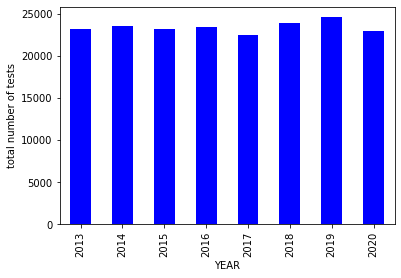

In [6]:
# number of tests each year
df['test_counter'] = 1
df.groupby('YEAR')['test_counter'].sum().plot(kind='bar', color='blue')
plt.ylabel('total number of tests')

Text(0, 0.5, 'share of fails (%)')

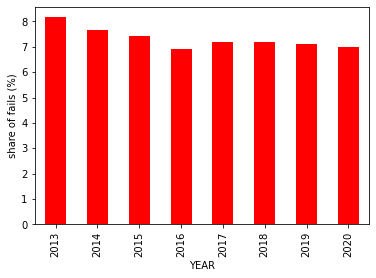

In [7]:
# share of failed tests each year
df['fail_counter'] = df.RESULT
(df.groupby('YEAR')['fail_counter'].mean()*100.0).plot(kind='bar', color='red')
plt.ylabel('share of fails (%)')

In [8]:
df = df.set_index(pd.DatetimeIndex(df.TEST_SDATE))
df = df.drop(columns='TEST_SDATE')
df.sort_values('TEST_SDATE', inplace=True)
df.head()

,RESULT,YEAR,2020,test_counter,fail_counter
TEST_SDATE,,,,,
2013-01-01 14:10:00,0,2013,0,1,0
2013-01-02 07:46:00,0,2013,0,1,0
2013-01-02 08:58:00,0,2013,0,1,0
2013-01-02 09:09:00,1,2013,0,1,1
2013-01-02 09:10:00,0,2013,0,1,0


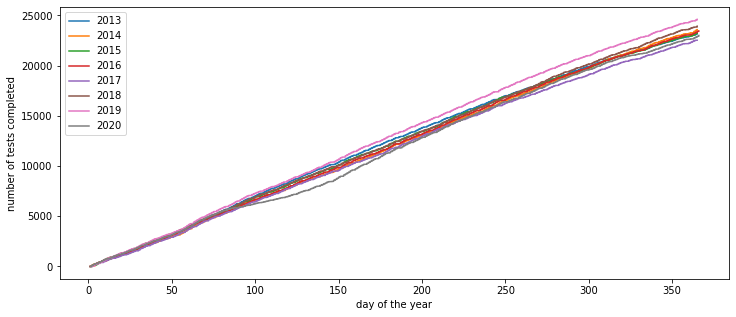

In [9]:
# number of tests along the year
plt.figure(figsize=(12, 5))
for year in df.YEAR.unique():
    t = df[df.YEAR==year].copy()
    t.index = t.index.dayofyear
    plt.plot(t.test_counter.cumsum(), label=f'{year}')
plt.legend()
plt.xlabel('day of the year')
plt.ylabel('number of tests completed');

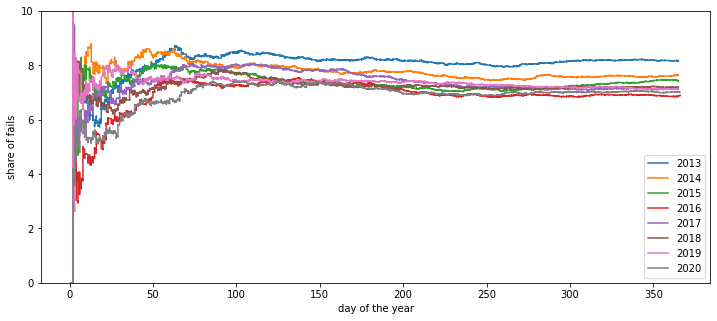

In [10]:
# share of fails along the year
plt.figure(figsize=(12, 5))
for year in df.YEAR.unique():
    t = df[df.YEAR==year].copy()
    t.index = t.index.dayofyear
    plt.plot(100.0*(t.fail_counter.cumsum()/t.test_counter.cumsum()), label=f'{year}')
plt.legend()
plt.ylim(0, 10)
plt.xlabel('day of the year')
plt.ylabel('share of fails');

## How different 2020 could have been with implementation of our solution?


###  predict for 2020

In [12]:
df_clean = load_data()
df_clean = clean_data(df_clean)

----------------start loading data----------------
Data loaded: 187503 records
----------------start cleaning data----------------

Records in input data: 187503

Share of Pass and Fail before cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10813
Unique vehicles in Pass: 84908

Records with missing GVWR: 8125

Records after droping rows where GVWR is < 1000 or missing: 179373

Records after keeping only the earliest test within a month for each vehicle: 165732

Records where AFTER_COVID is True: 21325

Records where ODOMETER = 0: 796

Records after droping rows where ODOMETER is missing: 164855

Records after droping rows where MILE_YEAR > 40,000: 163891

Records in output data:163891

Share of Pass and Fail after cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10194
Unique vehicles in Pass: 78573
['VEHICLE_TYPE' 'MODEL_YEAR' 'VEHICLE_AGE' 'MILE_YEAR' 'GVWR'
 'ENGINE_SIZE' 'TRANS_TYPE' 'TEST_TYPE' 'RESULT' 'MAKE'
 'ENGINE_WEIGHT_RATIO' 'SPORT' 'TEST_SDATE' 'AFTER_COVID']


In [13]:
# train < 2020, test 2020

df_clean['count_test'] = 1
df_clean['count_fail'] = df_clean.RESULT
train = df_clean[df_clean.TEST_SDATE.dt.year < 2020].sort_values('TEST_SDATE')
test = df_clean[df_clean.TEST_SDATE.dt.year == 2020].sort_values('TEST_SDATE')
y_train = train.pop('RESULT')
X_train = train
y_test = test.pop('RESULT')
X_test = test

# select features
cols = ['VEHICLE_AGE', 'MILE_YEAR', 'MAKE', 'MODEL_YEAR', 'ENGINE_WEIGHT_RATIO']

In [29]:
total_tests_2020 = X_test.shape[0]
total_fails_2020 = y_test.sum()

total_tests_2020, total_fails_2020

(20975, 1368)

**Favoring recall**


Best max_depth: 7

Features included: VEHICLE_AGE + MILE_YEAR + MAKE + MODEL_YEAR + ENGINE_WEIGHT_RATIO
Metric used: recall


,train,val,test
accuracy,0.642,0.636,0.702
recall,0.741,0.717,0.638
precision,0.135,0.131,0.132


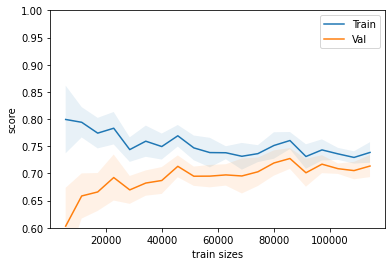

In [14]:
trainer = Trainer(X_train[cols], 
                  y_train,
                  metric='recall',
                  with_categorical=['MAKE'],
                  max_depth=[7]
         )
trainer.grid_search()
print('\nBest max_depth:', trainer.search_result.best_params_['model__max_depth'])
tmp = trainer.evaluate(X_test[cols], y_test)
trainer.learning_curve()
tmp

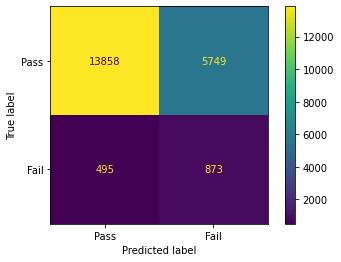

In [15]:
plot_confusion_matrix(trainer.search_result.best_estimator_, X_test[cols], y_test, display_labels=["Pass", "Fail"])

In [48]:
precision1 = 0.132
predicted_fails1 =  5749 + 873
true_fails1 = 873

**Favoring precision**


Features included: VEHICLE_AGE + MILE_YEAR + MAKE + MODEL_YEAR + ENGINE_WEIGHT_RATIO
Metric used: precision

Best max_depth: 5


,train,val,test
accuracy,0.620,0.617,0.736
recall,0.744,0.740,0.564
precision,0.128,0.128,0.135


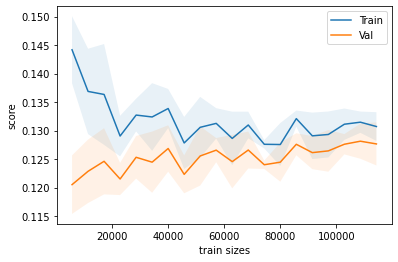

In [17]:
trainer2 = Trainer(X_train[cols], 
                  y_train,
                  metric='precision',
                  with_categorical=['MAKE'],
                  max_depth=[5]
         )
trainer2.grid_search()
trainer2.learning_curve()
print('\nBest max_depth:', trainer2.search_result.best_params_['model__max_depth'])
tmp = trainer2.evaluate(X_test[cols], y_test)
tmp

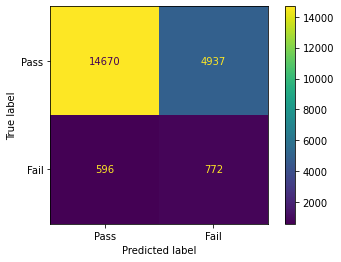

In [18]:
plot_confusion_matrix(trainer2.search_result.best_estimator_, 
                      X_test[cols], 
                      y_test, 
                      display_labels=["Pass", "Fail"])

In [49]:
precision2 = 0.135
predicted_fails2 = 4937 + 772
true_fails2 = 772

### 2020 with and without implementation of our solution

In [25]:
# add cum_tests and cum_fails columns
tmp = X_test[['TEST_SDATE', 'count_fail', 'count_test']].copy()
tmp.set_index(pd.DatetimeIndex(tmp.TEST_SDATE), inplace=True)
tmp['n_tests'] = tmp.count_test.cumsum()
tmp['n_fails'] = tmp.count_fail.cumsum()
tmp.drop(columns=['count_fail', 'count_test', 'TEST_SDATE'], inplace=True)
tmp.head()

,n_tests,n_fails
TEST_SDATE,,
2020-01-01 09:52:37,1,0
2020-01-01 13:44:43,2,0
2020-01-01 15:32:25,3,0
2020-01-01 15:51:44,4,0
2020-01-02 08:11:22,5,0


In [51]:
# define a function to create number of fails captured along 2020 with our solution

def fails_captured(data, precision, predicted_fails, true_fails, total_tests, total_fails):
    """ 
    params:
    data: pandas dataframe with two columns:
            n_tests: cumulative number of tests
            n_fails: cumulative number of failed tests
          and the dataframe is sorted by the index which is test dates
    precision: precision score on test set
    predicted_fails: number of fails predicted
    true_fails: number of predicted failed vehicles that acutally fail the test
    returns a panda series: number of fails captured along the time
    """
    df = data.copy()
    col = 'fails_captured'
    # first test all the predicted fails
    df[col] = df.n_tests * precision
    # changes after finish testing predicted fails
    tests_left = df[df.n_tests > predicted_fails].shape[0]
    fails_left = total_fails - true_fails
    avg_fail_per_test = fails_left/tests_left
    df.loc[df.n_tests > predicted_fails, col] = true_fails +\
        (df[df.n_tests > predicted_fails]['n_tests'] - predicted_fails)*avg_fail_per_test
    
    return df[col]

tmp['fails_captured_recall'] = fails_captured(tmp, 
                                              precision1, 
                                              predicted_fails1, 
                                              true_fails1, 
                                              total_tests_2020, 
                                              total_fails_2020
                                             )
tmp['fails_captured_precision'] = fails_captured(tmp, 
                                                 precision2, 
                                                 predicted_fails2, 
                                                 true_fails2,
                                                 total_tests_2020, 
                                                 total_fails_2020
                                                )
tmp.head()

,n_tests,n_fails,fails_captured_recall,fails_captured_precision
TEST_SDATE,,,,
2020-01-01 09:52:37,1,0,0.132,0.135
2020-01-01 13:44:43,2,0,0.264,0.270
2020-01-01 15:32:25,3,0,0.396,0.405
2020-01-01 15:51:44,4,0,0.528,0.540
2020-01-02 08:11:22,5,0,0.660,0.675


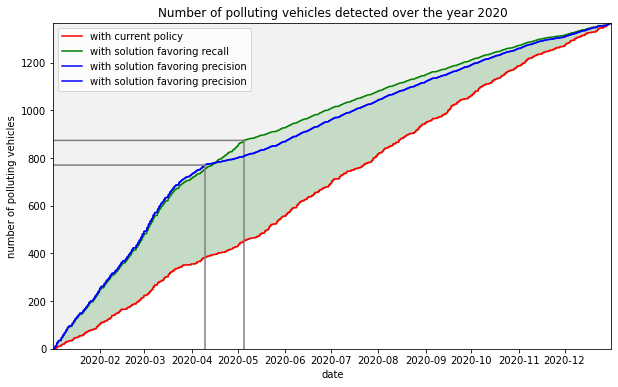

In [80]:
def plot_comparison(year, df, total_fails, predicted_fails1, predicted_fails2, plot_only='both'):
    
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, 
             df.n_fails, 
             label='with current policy', c='red')
    
    if plot_only == 'both' or plot_only == 'recall':
        
        plt.plot(df.index, 
                 df.fails_captured_recall, 
                 label='with solution favoring recall', c='green')
        # mark the time when all the predicted fail tests from recall favored model are completed
        t1 = df[df.n_tests==predicted_fails1].index[0]
        true_fails1 = df[df.n_tests==predicted_fails1].fails_captured_recall[0]
        plt.plot([t1 for i in range(100)], 
                 np.linspace(0, true_fails1, 100), c='grey')
        plt.plot(df[df.index < t1].index, 
                 [true_fails1 for i in range(df[df.index < t1].shape[0])], 
                 c='grey')
        plt.plot(df.index, 
                 df.fails_captured_precision, 
                 label='with solution favoring precision', c='blue')
        # fill the area corresponding to reduced pollution
        plt.fill_between(df.index,
                         df.n_fails,
                         df.fails_captured_recall,
                         color='green', alpha=0.1
                        )
        
    if plot_only == 'both' or plot_only == 'precision':
        plt.plot(df.index, 
                 df.fails_captured_precision, 
                 label='with solution favoring precision', c='blue')
        # mark the time when all the predicted fail tests from precision favored model are completed
        t2 = df[df.n_tests==predicted_fails2].index[0]
        true_fails2 = df[df.n_tests==predicted_fails2].fails_captured_precision[0]
        plt.plot([t2 for i in range(100)], 
                 np.linspace(0, true_fails2, 100), c='grey')
        plt.plot(df[df.index < t2].index, 
                 [true_fails2 for i in range(df[df.index < t2].shape[0])], 
                 c='grey')
        # fill in the area corresponding to reduced pollution
        plt.fill_between(df.index,
                         df.n_fails,
                         df.fails_captured_precision,
                         color='green', alpha=0.1
                        )
    # fill in the area corresponding to total pollution
    plt.fill_between(df.index,
                     df.n_fails,
                     [total_fails for i in range(df.shape[0])],
                     color='grey', alpha=0.1
                    )
    plt.ylim(0, total_fails)
    plt.xlim(df.index.min(), df.index.max())
    plt.ylabel('number of polluting vehicles')
    plt.xlabel('date')
    plt.legend()
    plt.title(f'Number of polluting vehicles detected over the year {year}')
    
plot_comparison(2020, tmp, total_fails_2020, predicted_fails1, predicted_fails2)

- green area corresponds to the reduced pollution by implementing our solution.
- In this case, favoring recall reduced more pollution than favoring precision.

## How different 2019 would be with our preliminary system?

### predict for 2019

In [81]:
# train < 2019, test 2019
train = df_clean[df_clean.TEST_SDATE.dt.year < 2019].sort_values('TEST_SDATE')
test = df_clean[df_clean.TEST_SDATE.dt.year == 2019].sort_values('TEST_SDATE')
y_train = train.pop('RESULT')
X_train = train
y_test = test.pop('RESULT')
X_test = test

# select features
cols = ['VEHICLE_AGE', 'MILE_YEAR', 'MAKE', 'MODEL_YEAR', 'ENGINE_WEIGHT_RATIO']

total_tests_2019 = X_test.shape[0]
total_fails_2019 = y_test.sum()

total_tests_2019, total_fails_2019

(22464, 1531)

**favoring recall**


Best max_depth: 5

Features included: VEHICLE_AGE + MILE_YEAR + MAKE + MODEL_YEAR + ENGINE_WEIGHT_RATIO
Metric used: recall


,train,val,test
accuracy,0.613,0.609,0.727
recall,0.751,0.743,0.598
precision,0.127,0.127,0.143


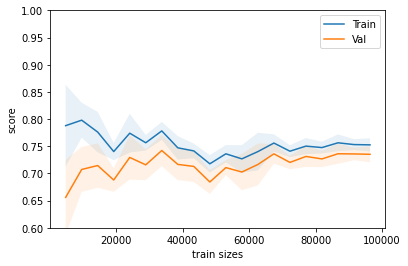

In [83]:
trainer = Trainer(X_train[cols], 
                  y_train,
                  metric='recall',
                  with_categorical=['MAKE'],
                  max_depth=np.arange(3, 10, 1)
         )
trainer.grid_search()
print('\nBest max_depth:', trainer.search_result.best_params_['model__max_depth'])
tmp = trainer.evaluate(X_test[cols], y_test)
trainer.learning_curve()
tmp

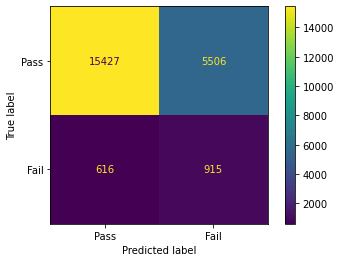

In [84]:
plot_confusion_matrix(trainer.search_result.best_estimator_, X_test[cols], y_test, display_labels=["Pass", "Fail"])

In [87]:
precision1 = 0.143
predicted_fails1 =  5506 + 915
true_fails1 = 915

**Favoring precision**


Features included: VEHICLE_AGE + MILE_YEAR + MAKE + MODEL_YEAR + ENGINE_WEIGHT_RATIO
Metric used: precision

Best max_depth: 7


,train,val,test
accuracy,0.654,0.647,0.740
recall,0.728,0.707,0.584
precision,0.138,0.134,0.146


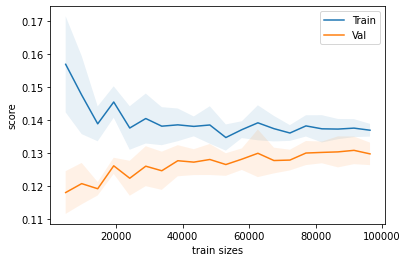

In [85]:
trainer2 = Trainer(X_train[cols], 
                  y_train,
                  metric='precision',
                  with_categorical=['MAKE'],
                  max_depth=np.arange(3, 10, 1)
         )
trainer2.grid_search()
trainer2.learning_curve()
print('\nBest max_depth:', trainer2.search_result.best_params_['model__max_depth'])
tmp = trainer2.evaluate(X_test[cols], y_test)
tmp

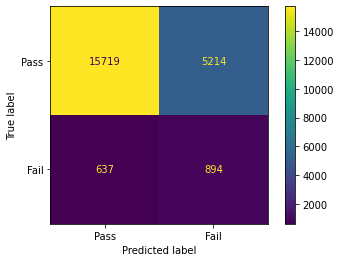

In [86]:
plot_confusion_matrix(trainer2.search_result.best_estimator_, 
                      X_test[cols], 
                      y_test, 
                      display_labels=["Pass", "Fail"])

In [88]:
precision2 = 0.146
predicted_fails2 = 5214 + 894
true_fails2 = 894

### 2019 with and without implementing our solution

In [89]:
# add cum_tests and cum_fails columns
tmp = X_test[['TEST_SDATE', 'count_fail', 'count_test']].copy()
tmp.set_index(pd.DatetimeIndex(tmp.TEST_SDATE), inplace=True)
tmp['n_tests'] = tmp.count_test.cumsum()
tmp['n_fails'] = tmp.count_fail.cumsum()
tmp.drop(columns=['count_fail', 'count_test', 'TEST_SDATE'], inplace=True)
tmp.head()

,n_tests,n_fails
TEST_SDATE,,
2019-01-02 08:00:59,1,0
2019-01-02 10:07:28,2,0
2019-01-02 10:29:34,3,0
2019-01-02 10:30:09,4,0
2019-01-02 10:47:54,5,0


In [93]:
tmp['fails_captured_recall'] = fails_captured(tmp, 
                                              precision1, 
                                              predicted_fails1, 
                                              true_fails1, 
                                              total_tests_2019, 
                                              total_fails_2019
                                             )
tmp['fails_captured_precision'] = fails_captured(tmp, 
                                                 precision2, 
                                                 predicted_fails2, 
                                                 true_fails2,
                                                 total_tests_2019, 
                                                 total_fails_2019
                                                )
tmp.head()

,n_tests,n_fails,fails_captured_recall,fails_captured_precision
TEST_SDATE,,,,
2019-01-02 08:00:59,1,0,0.143,0.146
2019-01-02 10:07:28,2,0,0.286,0.292
2019-01-02 10:29:34,3,0,0.429,0.438
2019-01-02 10:30:09,4,0,0.572,0.584
2019-01-02 10:47:54,5,0,0.715,0.730


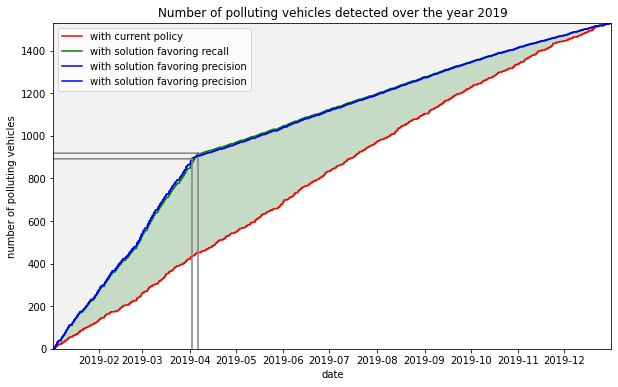

In [94]:
plot_comparison(2019, tmp, total_fails_2019, predicted_fails1, predicted_fails2)

# summary

In [ ]:
from emissions.implementer import Implementer
imp = Implementer()
imp.load_data()

----------------- getting best estimator favoring recall ----------------

Best max_depth: 5
           train    val   test
accuracy   0.620  0.617  0.736
recall     0.744  0.740  0.564
precision  0.128  0.128  0.135
--------------- getting best estimator favoring precision --------------

Best max_depth: 8
           train    val   test
accuracy   0.649  0.644  0.700
recall     0.744  0.709  0.635
precision  0.138  0.133  0.130

By the time 2020-04-09, 383 vehicles were off the road in reality
By the time 2020-04-09, 772 vehicles could have been off the road using model favoring recall

By the time 2020-05-05, 453 vehicles were off the road in reality
By the time 2020-05-05, 868 vehicles could have been off the road using model favoring precision


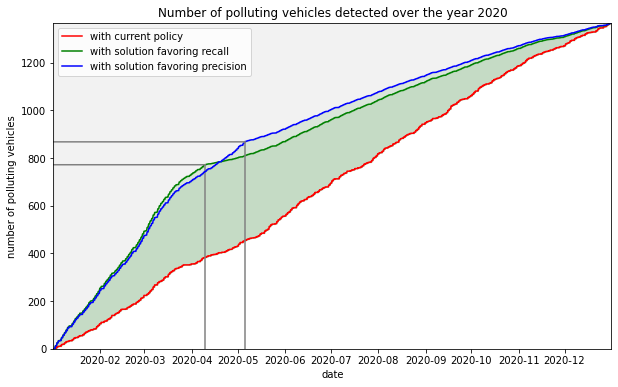

In [136]:
imp.implement(2020)

----------------- getting best estimator favoring recall ----------------

Best max_depth: 5
           train    val   test
accuracy   0.613  0.609  0.727
recall     0.751  0.743  0.598
precision  0.127  0.127  0.143
--------------- getting best estimator favoring precision --------------

Best max_depth: 7
           train    val   test
accuracy   0.654  0.647  0.740
recall     0.728  0.707  0.584
precision  0.138  0.134  0.146

By the time 2019-04-06, 452 vehicles were off the road in reality
By the time 2019-04-06, 915 vehicles could have been off the road using model favoring recall

By the time 2019-04-02, 435 vehicles were off the road in reality
By the time 2019-04-02, 894 vehicles could have been off the road using model favoring precision


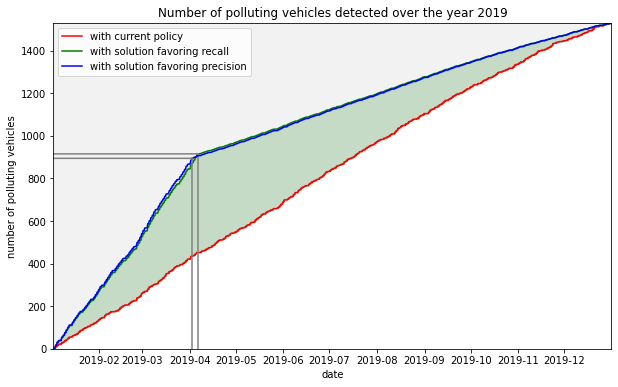

In [137]:
imp.implement(2019)


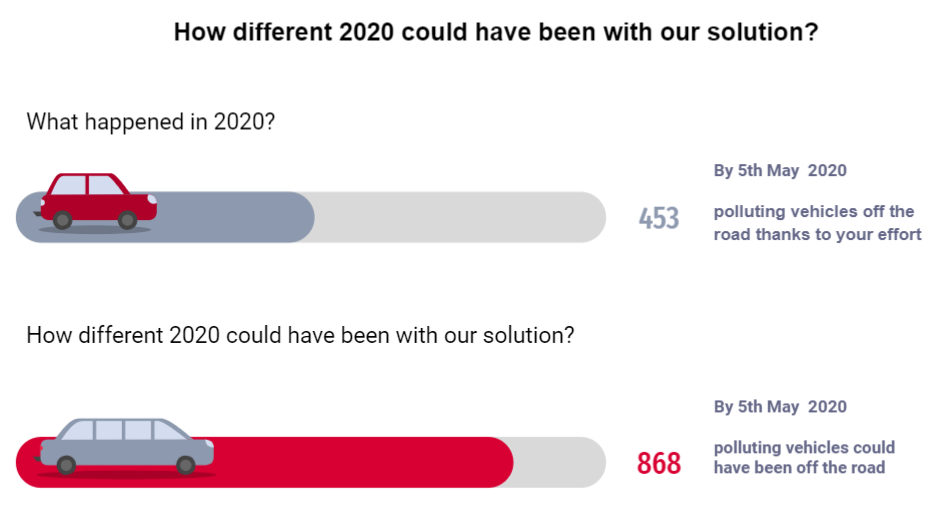
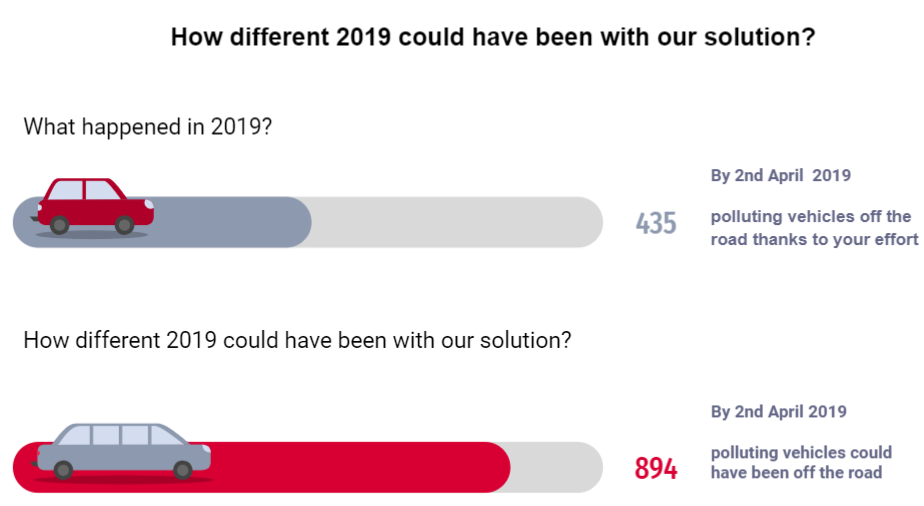